### Aim - Build a Fraud Detection System 'e-commerce'
- ingest data and perform initial EDA
- identify inherent data patterns including but not limited to - missing data or imbalanced dataset 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Section 1 : Exploratory Data Analysis

In [2]:
# Read the Parquet file
df = pd.read_parquet("../data.parquet", engine="pyarrow")  # or engine="fastparquet"

print("No. of items in dataset:", df.shape)

df.head(10)

No. of items in dataset: (519148, 5)


timestamp session_id device   price  is_fraud
0 2023-02-01 00:00:27.112402   6548112c    ios  212.99     False
1 2023-02-01 00:01:17.058324   6548112c    ios   37.99     False
2 2023-02-01 00:01:38.652451   6548112c    ios   68.99     False
3 2023-02-01 00:01:47.895385   6548112c    ios   61.99     False
4 2023-02-01 00:02:48.358924   6548112c    ios  633.99     False
5 2023-02-01 00:02:55.074778   6548112c    ios   62.99     False
6 2023-02-01 00:03:27.683215   6548112c    ios   25.99     False
7 2023-02-01 00:03:48.779966   6548112c    ios  160.99     False
8 2023-02-01 00:04:26.453811   6548112c    ios  175.99     False
9 2023-02-01 00:05:17.407882   6548112c    ios   84.99     False

In [3]:
# basic stats and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519148 entries, 0 to 519147
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   519148 non-null  datetime64[ns]
 1   session_id  519148 non-null  string        
 2   device      519148 non-null  string        
 3   price       519148 non-null  object        
 4   is_fraud    519148 non-null  bool          
dtypes: bool(1), datetime64[ns](1), object(1), string(2)
memory usage: 16.3+ MB


In [4]:
# display statistics for categorical data columns

df[['session_id', 'device', 'is_fraud']].describe()

session_id   device is_fraud
count      519148   519148   519148
unique      24428        2        2
top      37bb04bf  android    False
freq          908   293435   515985

In [5]:
# convert 'price' into numeric type for statistical summary
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Check if any values couldn't be converted
print("\nNumber of NaN values in price:", df['price'].isna().sum())

# Display statistics for the price column
print(df['price'].describe())


Number of NaN values in price: 0
count    519148.000000
mean        165.527342
std         196.658198
min           2.990000
25%          49.990000
50%          99.950000
75%         204.950000
max        1631.990000
Name: price, dtype: float64


In [6]:
# get class imbalance statistics
print("\nClass Distribution:\n", df['is_fraud'].value_counts(normalize=True) * 100)


Class Distribution:
 is_fraud
False    99.390733
True      0.609267
Name: proportion, dtype: float64


In [7]:
# analyze variation of fraudulent transactions wrt each of the variables - time, price, device & session_id
# identify any obvious patterns

def extract_time_features(df):
    """Extracts time-based features from timestamp."""
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
    return df

def compute_fraud_rates(df, group_by_column, col_name):
    """Computes fraud rates grouped by a specific column."""
    return df.groupby(group_by_column)["is_fraud"].mean() * 100

def categorize_price(df):
    """Creates price bins for fraud analysis."""
    price_bins = [0, 50, 100, 200, 500, 1000, 2000]
    labels = ["0-50", "50-100", "100-200", "200-500", "500-1000", "1000-2000"]
    df["price_category"] = pd.cut(df["price"], bins=price_bins, labels=labels)
    return df

def plot_fraud_rates(data, plot_type, title, xlabel, ylabel, ax, color="blue", palette="viridis"):
    """Generalized plotting function for fraud rates."""
    if plot_type == "line":
        sns.lineplot(x=data.index, y=data.values, ax=ax, marker="o", color=color)
    elif plot_type == "bar":
        sns.barplot(x=data.index, y=data.values, ax=ax, palette=palette)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

def analyze_fraud(df):
    """Performs fraud analysis and visualization."""
    df = extract_time_features(df)
    df = categorize_price(df)
    
    # Compute fraud rates
    fraud_by_hour = compute_fraud_rates(df, "hour", "Fraud Rate by Hour")
    fraud_by_day = compute_fraud_rates(df, "day_of_week", "Fraud Rate by Day")
    fraud_by_price = compute_fraud_rates(df, "price_category", "Fraud Rate by Price")
    fraud_by_device = compute_fraud_rates(df, "device", "Fraud Rate by Device")

    # Set up plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    plot_fraud_rates(fraud_by_hour, "line", "Fraud Rate by Hour of the Day", "Hour of the Day", "Fraud Rate (%)", axes[0, 0], color="red")
    plot_fraud_rates(fraud_by_day, "line", "Fraud Rate by Day of the Week", "Day of the Week (0=Monday, 6=Sunday)", "Fraud Rate (%)", axes[0, 1], color="blue")
    plot_fraud_rates(fraud_by_price, "bar", "Fraud Rate by Price Category", "Price Range ($)", "Fraud Rate (%)", axes[1, 0], palette="viridis")
    plot_fraud_rates(fraud_by_device, "bar", "Fraud Rate by Device Type", "Device Type", "Fraud Rate (%)", axes[1, 1], palette="viridis")

    plt.tight_layout()
    plt.show()

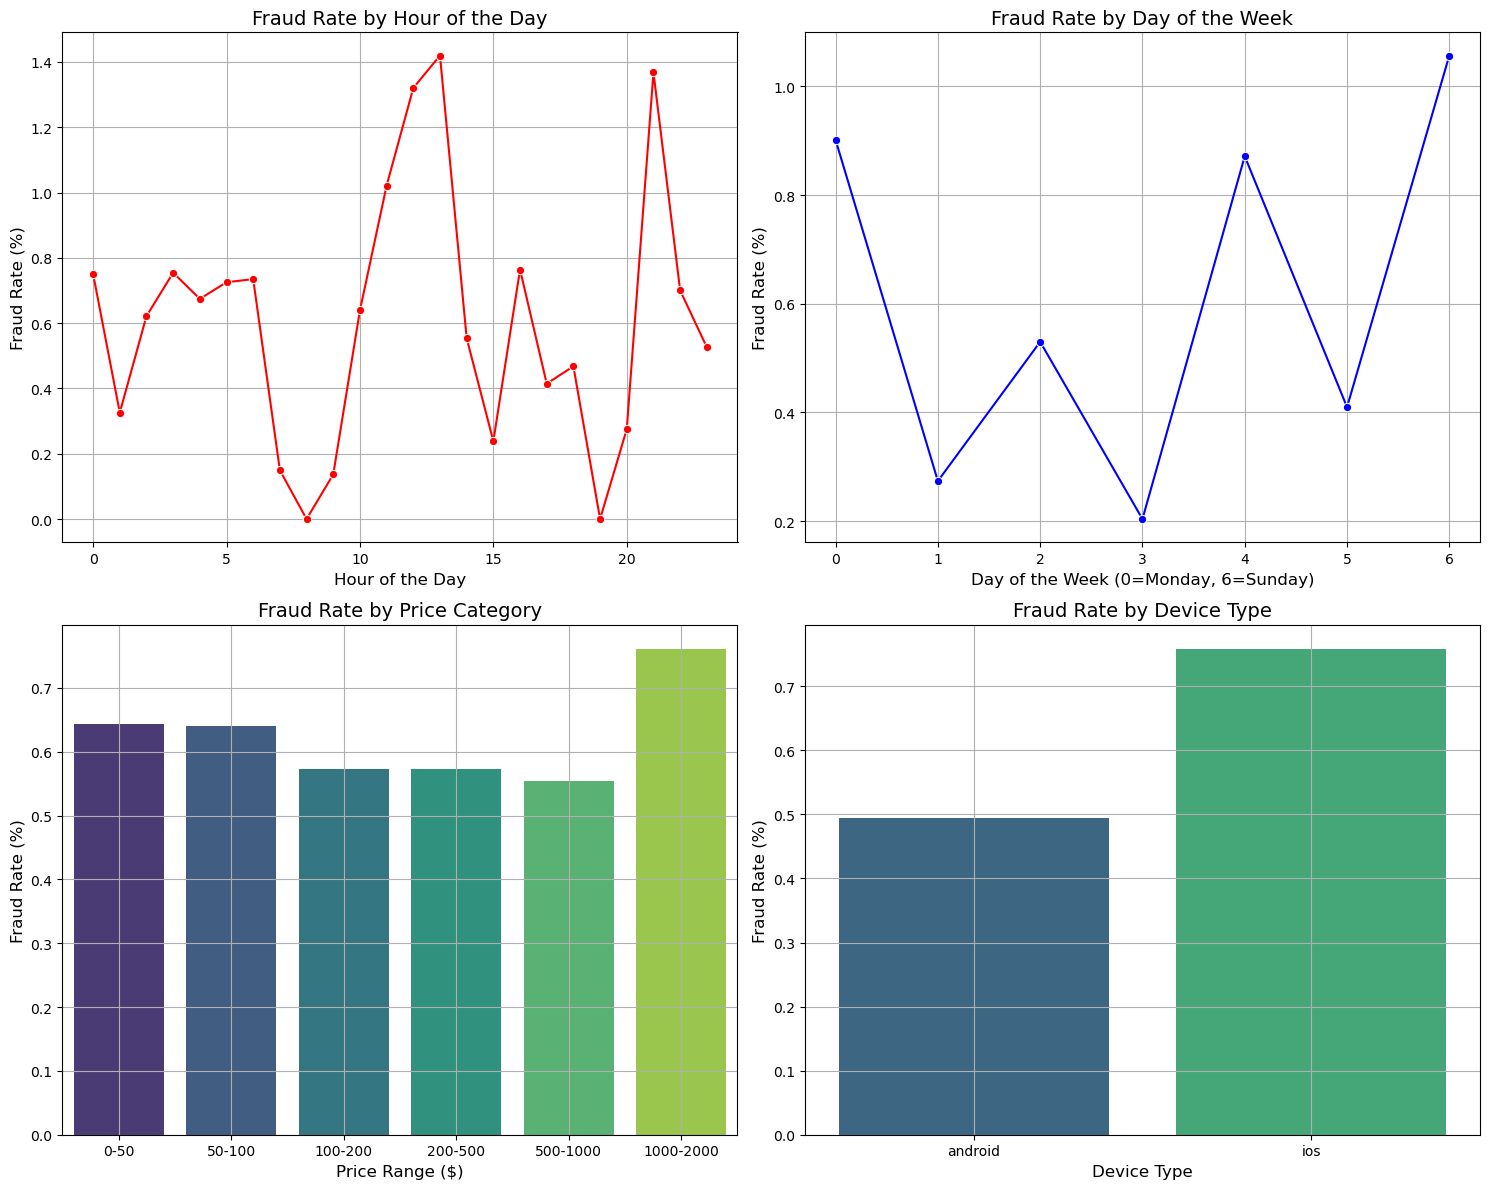

In [8]:
analyze_fraud(df)

In [20]:
# analyse session based fraud patterns

# Aggregate fraud counts per session
session_fraud_stats = df.groupby("session_id")["is_fraud"].agg(["sum", "count"])

# Rename columns
session_fraud_stats.columns = ["fraud_count", "total_transactions"]

# Calculate fraud rate per session
session_fraud_stats["fraud_rate"] = (session_fraud_stats["fraud_count"] / session_fraud_stats["total_transactions"]) * 100

# Sort by fraud rate (descending)
session_fraud_stats_sorted = session_fraud_stats.sort_values(by="fraud_rate", ascending=False)

In [19]:
# Display high-risk sessions
session_fraud_stats_sorted.head(50)

fraud_count  total_transactions  fraud_rate
session_id                                             
066a0b7a             36                  36       100.0
93609f23              8                   8       100.0
5e279db7            162                 162       100.0
74e8a5f6             64                  64       100.0
f0886d3c             56                  56       100.0
a603ced9             30                  30       100.0
e7452bd9            194                 194       100.0
5f19b84d             28                  28       100.0
02edc1aa             24                  24       100.0
ec1d6cb1             28                  28       100.0
7d97b06e             63                  63       100.0
14c3e78a            204                 204       100.0
96d09b0e            151                 151       100.0
a017126f            198                 198       100.0
cced15b4             81                  81       100.0
8d823c18            100                 100       100.0
c932616c             63                  63       100.0
64e9a431            347                 347       100.0
f6292501             52                  52       100.0
ff095398             22                  22       100.0
10bf51b0             10                  10       100.0
313157a7            149                 149       100.0
a3e49b8e             25                  25       100.0
30efb61a            153                 153       100.0
72f208b6             33                  33       100.0
26cd5902            329                 329       100.0
4ae8bdfe             31                  31       100.0
836a7a39             86                  86       100.0
984d025c             49                  49       100.0
2c02f853             10                  10       100.0
f4f783d5            377                 377       100.0
ab3c906a              0                   7         0.0
ab4191fb              0                  23         0.0
ab8ed514              0                   2         0.0
ab3d486a              0                  11         0.0
ab341c01              0                   8         0.0
ab391beb              0                  26         0.0
ab38ec54              0                  22         0.0
ab8ca7e7              0                 125         0.0
ab325ac2              0                  18         0.0
ab311ee1              0                  28         0.0
ab309410              0                  62         0.0
ab29141d              0                  13         0.0
ab8e6ff2              0                  12         0.0
ab6def92              0                  33         0.0
ab84d545              0                  13         0.0
ab5421f2              0                  16         0.0
ab5e503f              0                   5         0.0
ab72cbea              0                   8         0.0
ab762ecf              0                  37         0.0

In [22]:
# Calculate percentages
total_sessions = len(session_fraud_stats_sorted)
fraudulent_sessions = (session_fraud_stats_sorted["fraud_rate"] > 0).sum()
non_fraudulent_sessions = total_sessions - fraudulent_sessions

fraud_percent = (fraudulent_sessions / total_sessions) * 100
non_fraud_percent = (non_fraudulent_sessions / total_sessions) * 100

# Print results
print(f"Percentage of Fraudulent Sessions: {fraud_percent:.2f}%")
print(f"Percentage of Non-Fraudulent Sessions: {non_fraud_percent:.2f}%")


Percentage of Fraudulent Sessions: 0.13%
Percentage of Non-Fraudulent Sessions: 99.87%



### Summary of Exploratory Data Analysis (EDA) for Fraud Detection  

#### 1. Class Imbalance  
- Fraud Cases (`is_fraud=1`) are very rare (~0.6% of transactions)
- Non-Fraud Transactions (`is_fraud=0`) dominate the dataset (~99.4%)  
- **Impact:** Typical characteristic of  "rare event datasets" or "skewed class datasets" 

#### 2. Time-Based Patterns in Fraud  
- Fraud is concentrated at specific hours:  
  - **High fraud hours:** `11 AM - 2 PM`, `9 PM - 10 PM`.  
  - **Impact:** Fraud detection models should weigh time features heavily.  
- Fraud is more common on weekends and specific weekdays:  
  - **Highest fraud day:** **Sunday**.  
  - **Followed by:** **Monday and Friday**.  

#### 3. Price-Based Insights  
- **Fraud occurs across the price spectrum**, but:  
  - High-priced transactions comparatively($1,000+) show more fraud.
  - Fraud cases often deviate from session price averages.
- Price variance within a session is higher for fraudulent transactions. 

#### 4. Session-Based Fraud Indicators  
- **Fraudulent transactions tend to occur in repeated sessions rather than one-offs.**  
- **Potential fraud risk factors in sessions:**  
      - Multiple orders in a short time (high session order velocity) 

#### 5. Transaction Frequency & Timing Patterns  
- **Fraudulent users place more orders per session than non-fraud users.**


#### Key Insights  
- Fraud is not randomâ€”it follows specific patterns based on time, price, and session behavior  
- iOS devices are linked to comparatively more fraudulent transactions than Android.
- Repeated fraudulent transactions are observed from specific sessions 
- Fraud detection models should prioritize time-based, session-based, and price-based features, such as
    - Unusual price patterns (e.g., extreme high or low prices).
    - High activity during off-peak hours (e.g., late nights and weekends).
    - Multiple orders per session with short intervals.
    - Bursts of activity over time.



----

#### Section 2 : Simple Rule Based System
- based on the above EDA findings, explore a simple yet efficient `rule based system`
    - that identifies potential fraudulent transactions
- calculate the system's efficiency
    - business KPIs : generated profit 

In [9]:
# helper function
def precompute_fraud_patterns(df):
    """
    Precomputes fraud indicators from historical transaction data.
    
    Returns:
    - session_fraud_dict: A dictionary mapping session_id to whether it had fraud.
    - fraud_high_risk_hours: List of high-risk hours.
    - fraud_high_risk_days: List of high-risk days.
    """
    session_fraud_dict = df.groupby("session_id")["is_fraud"].max().to_dict()  # Track past fraud sessions
    fraud_high_risk_hours = [11, 12, 13, 14, 21, 22]  # Precomputed from EDA
    fraud_high_risk_days = [0, 4, 6]  # (Monday, Friday, Sunday)

    return session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days


def simple_fraud_detection(transaction, session_stats, session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days):
    """
    Rule based fraud detection for a single transaction.
    
    Returns:
    - True if transaction is flagged as fraud, False otherwise.
    """
    session_id = transaction["session_id"]
    
    # Get session-level stats (default values if session not found)
    session_orders = session_stats.get(session_id, {}).get("session_total_orders", 1)
    session_spend = session_stats.get(session_id, {}).get("session_total_spend", transaction["price"])
    session_duration = session_stats.get(session_id, {}).get("session_duration", 0)
    device_switches = session_stats.get(session_id, {}).get("device_switches", 1)
    
    # Apply relaxed fraud detection rules (requires multiple conditions)
    if ((session_orders > 50 and session_spend > 1000) or
         (transaction["hour"] in fraud_high_risk_hours and transaction["day_of_week"] in fraud_high_risk_days)):
        return True  # Flagged as fraud
    
    return False  # Legitimate transaction


def calculate_profit(transactions, fraud_detection_func, session_stats, session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days):
    """
    Calculates profit for transactions processed in real time.

    Arguments:
    - transactions: List of transactions to process.
    - fraud_detection_func: The fraud detection function (rule based function here).

    Returns:
    - Total profit.
    """
    profit = 0

    for transaction in transactions:
        is_fraudulent = fraud_detection_func(transaction, session_stats, session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days)

        if not is_fraudulent:  # Accepted transaction
            if not transaction["is_fraud"]:
                profit += float(transaction["price"]) * 0.01  # Convert price to float
            else:
                profit -= float(transaction["price"])  # Convert price to float
    
    return profit

In [10]:
# Compute session-level statistics (historical data)
session_stats_df = df.groupby("session_id").agg(
    session_total_orders=("session_id", "count"),
    session_total_spend=("price", "sum"),
    session_duration=("timestamp", lambda x: (x.max() - x.min()).total_seconds()),
    device_switches=("device", "nunique"),
).to_dict(orient="index")

# Precompute fraud risk knowledge
session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days = precompute_fraud_patterns(df)

# Convert dataframe to a list of transactions (real-time simulation)
transactions = df.to_dict(orient="records")

In [11]:
# Compute profits
baseline_profit = sum([float(t["price"]) * 0.01 if not t["is_fraud"] else -float(t["price"]) for t in transactions])
rule_based_system_profit = calculate_profit(transactions, simple_fraud_detection, session_stats_df, session_fraud_dict, fraud_high_risk_hours, fraud_high_risk_days)

# Calculate uplift
uplift = rule_based_system_profit - baseline_profit

# Print results
print("=== Fraud Detection System Performance ===")
print(f"Baseline Profit (No Fraud Detection): ${baseline_profit:.2f}")
print(f"Simple Rule-Based System Profit: ${rule_based_system_profit:.2f}")
print(f"Profit Uplift: ${uplift:.2f}")

=== Fraud Detection System Performance ===
Baseline Profit (No Fraud Detection): $341572.38
Simple Rule-Based System Profit: $462813.64
Profit Uplift: $121241.26


-----
EOF